In [3]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import numpy as np
from collections import Counter
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdMolDescriptors

In [4]:
import logging, sys
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler(sys.stdout)
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [5]:
# Load bioassay results
ba_df = pd.read_csv("AID_1030_datatable_all.csv")

# Load compound SMILES info
cs_df = pd.read_csv("AID_1030_compound_smiles.csv",sep='\t',header=0)

# Merge the two
full_df = ba_df.merge(cs_df,on='PUBCHEM_CID')

# Cleanup the compound ID column
full_df["PUBCHEM_CID"] = full_df["PUBCHEM_CID"].astype(int)
full_df["PUBCHEM_ACTIVITY_SCORE"] = full_df["PUBCHEM_ACTIVITY_SCORE"].astype(int)


/home/joe/anaconda3/envs/pubchem-sklearn/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,8,9,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


count       220365
unique           3
top       Inactive
freq        148299
Name: PUBCHEM_ACTIVITY_OUTCOME, dtype: object
['Inconclusive' 'Inactive' 'Active']


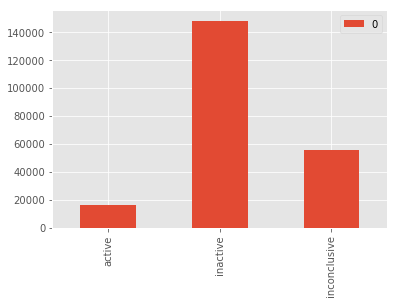

In [6]:
outcomes = full_df["PUBCHEM_ACTIVITY_OUTCOME"]
print(outcomes.describe())
print(outcomes.unique())

# Calculate the frequency of each of the outcomes
c = Counter(outcomes)
active_count = c["Active"]
inactive_count = c["Inactive"]
inconclusive_count = c["Inconclusive"]

# Plot a histogram of outcomes
%matplotlib inline

df_overview = pd.DataFrame(data=[active_count, inactive_count, inconclusive_count]
                          ,index=['active','inactive','inconclusive'])

df_overview.plot(kind='bar')

In [7]:
# Delete CID 3246048, which fails featurization
full_df = full_df[full_df["PUBCHEM_CID"] != 3246048]

# Delete all inconclusive results
full_df = full_df[full_df["PUBCHEM_ACTIVITY_OUTCOME"] != "Inconclusive"]

count       164410
unique           2
top       Inactive
freq        148299
Name: PUBCHEM_ACTIVITY_OUTCOME, dtype: object
['Inactive' 'Active']
Active: 16111, Inactive: 148299


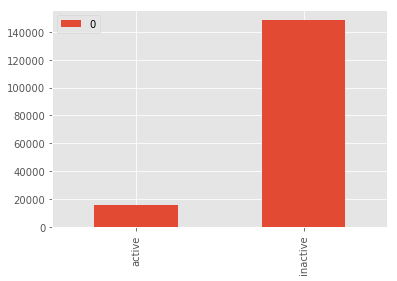

In [8]:
outcomes = full_df["PUBCHEM_ACTIVITY_OUTCOME"]
print(outcomes.describe())
print(outcomes.unique())

# Calculate the frequency of each of the outcomes
c = Counter(outcomes)
active_count = c["Active"]
inactive_count = c["Inactive"]
inconclusive_count = c["Inconclusive"]
print("Active: {}, Inactive: {}".format(active_count,inactive_count))

# Plot a histogram of outcomes
%matplotlib inline

df_overview = pd.DataFrame(data=[active_count, inactive_count]
                          ,index=['active','inactive'])

df_overview.plot(kind='bar')

SMILES: C1CCC(C1)N(CC(=O)NCC2=CC=CS2)C(=O)C3=CC4=C(S3)CCC4
2017-09-28 13:52:29,075 - DEBUG - STREAM b'IHDR' 16 13
2017-09-28 13:52:29,075 - DEBUG - STREAM b'bKGD' 41 6
2017-09-28 13:52:29,076 - DEBUG - b'bKGD' 41 6 (unknown)
2017-09-28 13:52:29,076 - DEBUG - STREAM b'IDAT' 59 5842


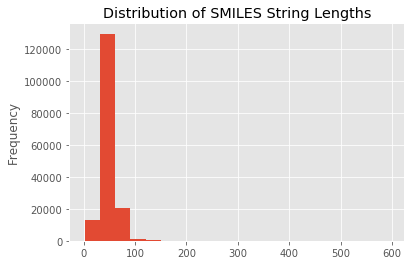

In [ ]:
# Now, let's look at the column we'll be using to derive our features. This is the "smiles" column
smiles = full_df["Smiles"]
# Let's look at a sample indicies
smile_1 = smiles[100]
print("SMILES: {}".format(smile_1))
mol_1 = Chem.MolFromSmiles(smile_1)
#Draw.ShowMol(mol_1)
Draw.MolsToGridImage([mol_1])

smiles_lengths = pd.Series([len(s) for s in smiles])
smiles_lengths.describe()

%matplotlib inline
smiles_lengths.plot.hist(bins=20,title="Distribution of SMILES String Lengths")

In [ ]:
# Now let's look at the actual feature fingerprints, calculating them

fingerprints = list()
fingerprints_np = list()
cids = list()
activities = list()

for index, row in full_df.iterrows() :
    cid = row["PUBCHEM_CID"]
    smiles_string = row["Smiles"]
    mol = Chem.MolFromSmiles(smiles_string)
    is_active = row["PUBCHEM_ACTIVITY_OUTCOME"] == "Active"
    if mol is None:
        logger.info("Molecule failed featurization")
        logger.info(index)
    else: 
        fingerprint = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol,2,nBits=2048,useChirality=False,
                                                                     useBondTypes=False,useFeatures=False)
    # From RDKit documentation
    fingerprints.append(fingerprint)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fingerprint, arr)
    fingerprints_np.append(arr)
    cids.append(cid)
    activities.append(is_active)
    
    if index % 10000 == 0:
        logger.info("Processed index: {0}".format(index))
    
fp_arr = np.array(fingerprints)
activities_arr = np.array(activities,dtype=bool)


2017-09-28 13:52:32,918 - INFO - Processed index: 10000
2017-09-28 13:52:38,525 - INFO - Processed index: 30000
2017-09-28 13:52:41,444 - INFO - Processed index: 40000
2017-09-28 13:52:44,409 - INFO - Processed index: 50000
2017-09-28 13:52:47,462 - INFO - Processed index: 60000
2017-09-28 13:52:53,455 - INFO - Processed index: 80000
2017-09-28 13:52:56,399 - INFO - Processed index: 90000
2017-09-28 13:52:59,424 - INFO - Processed index: 100000
2017-09-28 13:53:02,442 - INFO - Processed index: 110000
2017-09-28 13:53:05,534 - INFO - Processed index: 120000
2017-09-28 13:53:08,684 - INFO - Processed index: 130000
2017-09-28 13:53:11,839 - INFO - Processed index: 140000
2017-09-28 13:53:14,971 - INFO - Processed index: 150000
2017-09-28 13:53:21,158 - INFO - Processed index: 170000
2017-09-28 13:53:33,252 - INFO - Processed index: 210000
2017-09-28 13:53:36,854 - INFO - Processed index: 220000


In [ ]:
df_undersampled = pd.DataFrame(data={'fingerprint' : fingerprints, 'active': activities_arr},index=cids)

In [2]:
c = Counter(activities)
active_count = c[True]
inactive_count = c[False]
print("Active: {}, Inactive: {}".format(active_count,inactive_count))

# Plot a histogram of outcomes
%matplotlib inline

df_overview = pd.DataFrame(data=[active_count, inactive_count]
                          ,index=['active','inactive'])

df_overview.plot(kind='bar')

NameError: name 'activities' is not defined

In [ ]:
fpBitCount = Counter()
for fp in df_undersampled['fingerprints'] :
    for bit in fp.GetOnBits():
        fpBitCount[bit]+=1

In [ ]:
mostCommonBits = fpBitCount.most_common(10)
labels = [i for i,j in mostCommonBits]
values = [j for i,j in mostCommonBits]
df_overview = pd.DataFrame(data=values
                          ,index=labels)
df_overview.plot(kind='bar')
print(mostCommonBits)

In [ ]:
# Now, let's undersample to obtain an even percentage of active and inactive samples

fingerprints = np.array(fingerprints)
activities = np.array(activities,dtype=int)
        
logger.info("Undersampling")

rus = RandomUnderSampler(random_state=global_random_state)
X, y = rus.fit_sample(fingerprints, activities)

# Let's look again at data distribution
pd.Series(y).plot.hist()

fpBitCount = Counter()
for fp in fingerprints :
    for bit in fp.GetOnBits():
        fpBitCount[bit]+=1
        
mostCommonBits = fpBitCount.most_common(10)
labels = [i for i,j in mostCommonBits]
values = [j for i,j in mostCommonBits]
df_overview = pd.DataFrame(data=values
                          ,index=labels)
df_overview.plot(kind='bar')
print(mostCommonBits)


In [ ]:
logger.removeHandler(ch)
ch.close()